In [15]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import netket as nk

In [16]:
from src.qm_utils.lattice.lattice import Lattice2D
from src.qm_utils.lattice.brillouin_zone import BrillouinZone2D
from src.netket_compat import get_sector_constraints
from src.acband import projected_hamiltonian

In [17]:
sqrt3 = np.sqrt(3)
e1 = np.array([1, 0])
e2 = np.array([0, 1])
a_M = 1.0
a1 = a_M * e2
a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
lattice = Lattice2D(np.stack([a1, a2]))
b = (4 * np.pi) / (a_M * sqrt3)
b1, b2 = lattice.reciprocal_lattice_vectors
b3 = -(b1 + b2)

# N = 27 grid
t1 = (1 / 9) * (b1 - b2)
t2 = (1 / 9) * (b1 - b3)

sample_lattice_27 = Lattice2D(np.stack([t1, t2]))
bz_27 = BrillouinZone2D(lattice, sample_lattice_27)
N_s_27 = bz_27.n_samples

# N = 28 grid
p1 = b1 + t2 - t1
normb1 = np.linalg.norm(b1)
normp1 = np.linalg.norm(p1)
distb1p1 = np.linalg.norm(b1 - p1)
scale = normb1 / normp1
rot = -np.arccos((normb1 ** 2 + normp1 ** 2 - distb1p1 ** 2) / (2 * normb1 * normp1))
sample_lattice_28 = sample_lattice_27.transformed(scale=scale, rot=rot)

bz_28 = BrillouinZone2D(lattice, sample_lattice_28)
N_s_28 = bz_28.n_samples

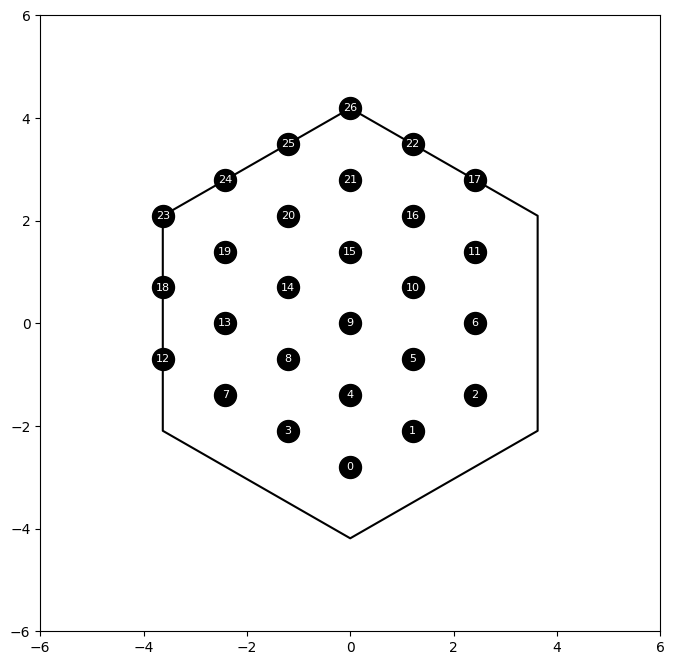

In [18]:
sampled_momentums = bz_27.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_27):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.show()

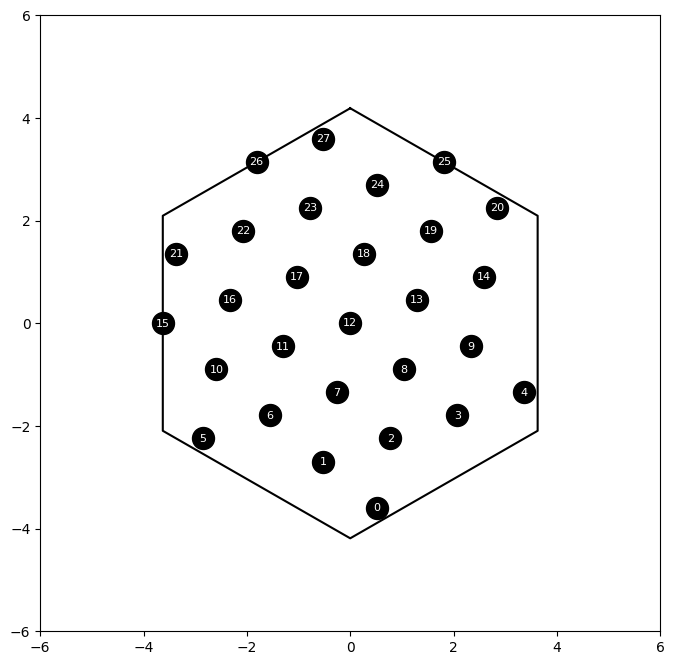

In [19]:
sampled_momentums = bz_28.k_points
R = 3 * np.linalg.norm(t1)
thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
hexagon_x = R * np.cos(thetas)
hexagon_y = R * np.sin(thetas)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
k_x = sampled_momentums[:, 0]
k_y = sampled_momentums[:, 1]
ax.scatter(k_x, k_y, s=250, c='k')
for i in range(N_s_28):
    x = k_x[i]
    y = k_y[i]
    ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

ax.plot(hexagon_x, hexagon_y, color='k')

ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.show()

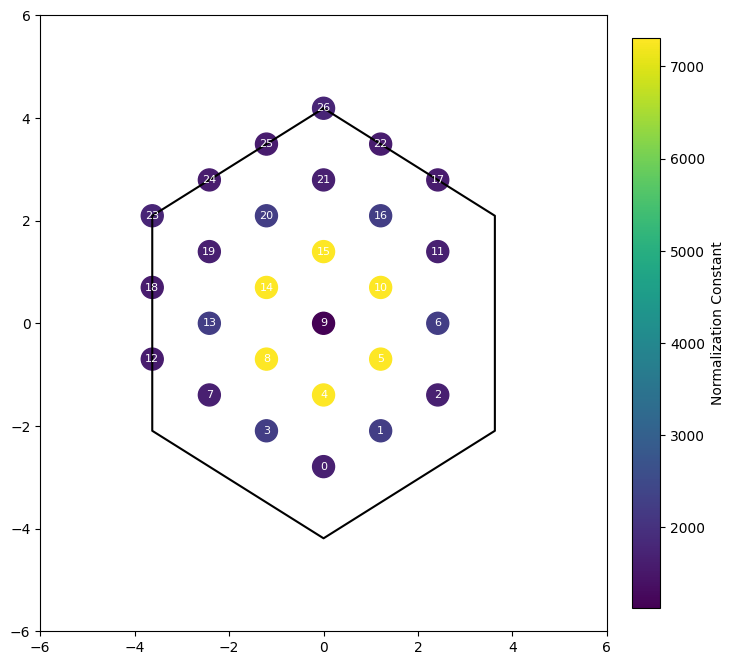

In [ ]:
    from functools import partial
    import time
    from src.acband import (
        K_func1,
        K_fourier_components,
        acband_normalization_constants,
    )

    lB = 1.0
    # resolution = 126
    resolution = 254
    K_func = partial(K_func1, args=(0.8, b1, b2, b3))

    # normalization constants test
    g_coords, wg = K_fourier_components(
        K_func, bz_27.lattice, resolution, flatten=False
    )
    normalizations = acband_normalization_constants(
        bz_27, lB, g_coords, wg, eps=1e-5
    )

    sampled_momentums = bz_27.k_points
    R = 3 * np.linalg.norm(t1)
    thetas = np.linspace(np.pi / 2, 5 * np.pi / 2, 7)
    hexagon_x = R * np.cos(thetas)
    hexagon_y = R * np.sin(thetas)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    k_x = sampled_momentums[:, 0]
    k_y = sampled_momentums[:, 1]

    # 1. scatter 객체를 변수(sc)에 저장
    sc = ax.scatter(k_x, k_y, s=250, c=normalizations, cmap='viridis') # cmap은 원하는대로 변경 가능

    for i in range(N_s_27):
        x = k_x[i]
        y = k_y[i]
        ax.text(x, y, f"{i}", fontsize=8, color="w", ha='center', va='center')

    ax.plot(hexagon_x, hexagon_y, color='k')

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    # 2. fig.colorbar에 scatter 객체 전달
    # fraction, pad 등으로 컬러바 크기와 위치 미세 조정 가능
    cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalization Constant') # 필요시 라벨 추가

    plt.show()